Model orthogonalization with LDM variants (heavily based on Vojta's original code "toymodels.ipynb"). This is an interactive jupyter notebook, that will explore different choices for the construction of the principal components. For now we will only play with the following scenarios:


* 1 good model 1 bad model
* 3 good model 10 bad models



This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants
        ├── 4 classes, 2 models of each class
        ├── 1 good model 7 bad models
        ├── 4 good models 4 bad models
        ├── 7 good models 1 bad model
        ├── 1 model perfect 7 models bad
        ├── 8 perfect models with a various scales random corruption
        ├── 1 model perfect 8 other models
        ├── 1 good model 1 bad model
        ├── 2 good models 10 bad models
    └── PCA - Analysis
        ├── Raw model output  -  not standardized
        ├── Raw model output  -  standardized
        ├── Residuals - not standardized
        ├── Residuals - standardized
        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [51]:
pip install corner 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import corner 

#def LDM_extended(params, x):
#    #x = (n,z)
#    #params= parameters (volume, surface, curv, sym, ssym, sym_2)
#    
#    n=x[0]
#    z=x[1]
#    A = n + z
#    I = (n-z)/(n+z)
#    #I = 0
#
#    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
#                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4)

def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 




def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    #input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ = pd.read_csv("NZ_even_even.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return


def plot_bars(values, labels, title="Bar Plot", color='blue'):
    """
    Create a bar plot based on the provided values and labels.

    Parameters:
    - values (list): A list of numerical values for the bars.
    - labels (list): A list of labels for each bar.
    - title (str): The title for the bar plot. Default is "Bar Plot".
    - color (str): Color for the bars. Default is 'blue'.
    """
    
    if len(values) != len(labels):
        raise ValueError("Length of values and labels should be the same.")
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Vt Coordinates')
    plt.xticks(labels,fontsize=10,rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()




### Global variables####

# SkO values selected for the truth
#truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5]
truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 values selected for the truth
SLY_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1 params
NL1_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]
corruption_noise_Mass=0

c1_params = [SLY_params, NL1_params]
c2_params = [[-15.972, 18.4, 9, 32.01, -54, 0, 0.57], [-16.425, 18.8, 9, 43.48, -110, 0, 0.57]]
c3_params = [[-15.972, 18.4, 9, 32.01, 0, 0, 0.57], [-16.425, 18.8, 9, 43.48, 0, 0, 0.57]]
c4_params = [[-15.972, 18.4, 9, 0, 0, 0, 0.57], [-16.425, 18.8, 9, 0, 0, 0, 0.57]]


noise_term=0.01

##########################

## Version 2.0 - LDM variants

### Scenario - 1 good model 1 bad model

In [27]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g1b"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

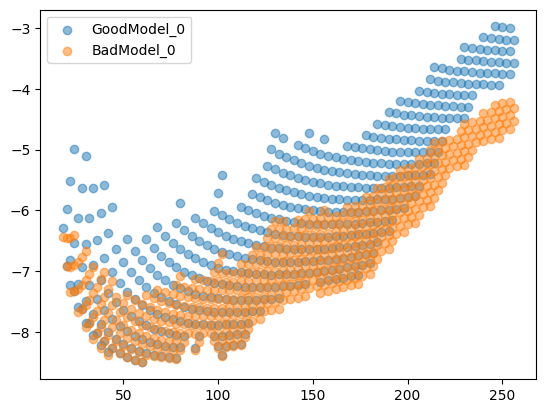

In [28]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.144931  1.333014 -0.127373  0.074306  0.147462
BadModel_0  -6.737253  1.034223  0.464949  0.362469  0.589543
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.14 & 1.33 & -0.13 & 0.07 & 0.15 \\
BadModel_0 & -6.74 & 1.03 & 0.46 & 0.36 & 0.59 \\
\end{tabular}



### Scenario - 1 good model 1 bad models (noise)

In [340]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g1bNoise"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)+str("_noise")] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)+str("_noise")] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

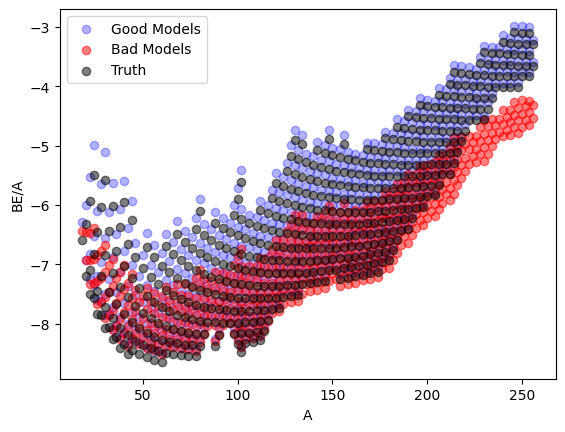

In [374]:
key_list=list(models_output.keys())


legend_flag=0
for key in key_list[0:1]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = 'Good Models', alpha = 0.3,color='b')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.3,color='b')

legend_flag=0
for key in key_list[1:]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = "Bad Models", alpha = 0.5,color='r')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.5,color='r')


plt.scatter(x = models_output_df["A"], y = masses_truth, label = "Truth", alpha = 0.5,color='k')
plt.xlabel("A")
plt.ylabel("BE/A")
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [345]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                       mean       std  res_mean  res_std      rmse
GoodModel_0_noise -6.145730  1.332457 -0.123378  0.05987  0.137137
BadModel_0_noise  -6.737361  1.035134  0.468252  0.36148  0.591547
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0_noise & -6.15 & 1.33 & -0.12 & 0.06 & 0.14 \\
BadModel_0_noise & -6.74 & 1.04 & 0.47 & 0.36 & 0.59 \\
\end{tabular}



### Scenario - 3 good model 10 bad models

In [26]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "3g10b"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 3
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])


n_class_4 = 10
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

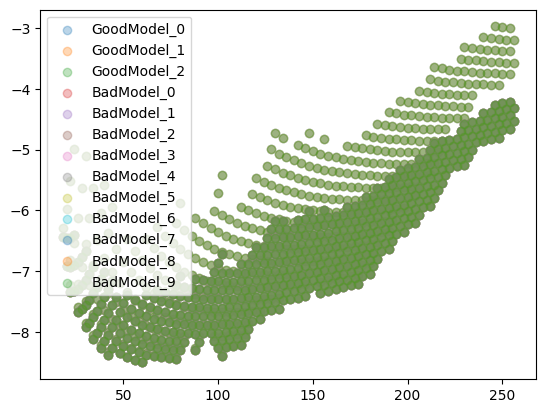

In [27]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [28]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.144931  1.333014 -0.124178  0.059382  0.137646
GoodModel_1 -6.144931  1.333014 -0.124178  0.059382  0.137646
GoodModel_2 -6.144931  1.333014 -0.124178  0.059382  0.137646
BadModel_0  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_1  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_2  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_3  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_4  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_5  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_6  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_7  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_8  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_9  -6.737253  1.034223  0.468144  0.362202  0.591903
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.14 & 1.33 & -0.12 & 0.06 & 0.14 \\
GoodModel_1

### Scenario - 3 good model 10 bad models (noise)

In [72]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "3g10bNoise"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 3
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term


n_class_4 = 10
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

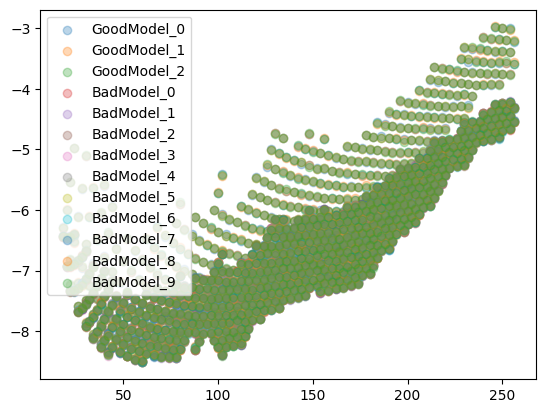

In [73]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

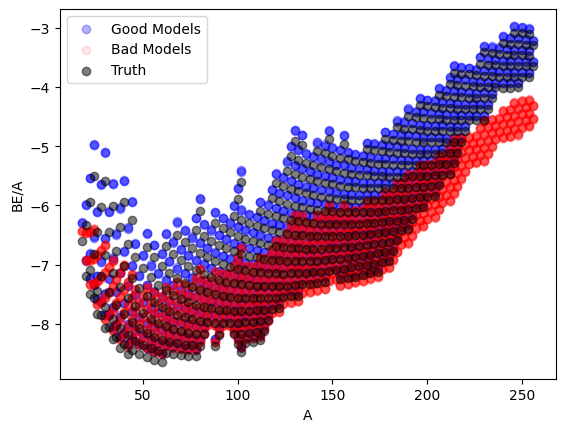

In [335]:
key_list=list(models_output.keys())


legend_flag=0
for key in key_list[0:3]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = 'Good Models', alpha = 0.3,color='b')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.3,color='b')

legend_flag=0
for key in key_list[3:]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = "Bad Models", alpha = 0.1,color='r')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.1,color='r')


plt.scatter(x = models_output_df["A"], y = masses_truth, label = "Truth", alpha = 0.5,color='k')
plt.xlabel("A")
plt.ylabel("BE/A")
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [74]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.145730  1.332457 -0.123378  0.059870  0.137137
GoodModel_1 -6.145039  1.333945 -0.124070  0.059985  0.137810
GoodModel_2 -6.144601  1.333108 -0.124508  0.060236  0.138313
BadModel_0  -6.737705  1.034528  0.468596  0.361950  0.592107
BadModel_1  -6.738154  1.034941  0.469046  0.361836  0.592393
BadModel_2  -6.737486  1.034937  0.468377  0.361903  0.591905
BadModel_3  -6.737645  1.034513  0.468536  0.362509  0.592401
BadModel_4  -6.737267  1.034625  0.468158  0.361943  0.591756
BadModel_5  -6.737202  1.033974  0.468094  0.362741  0.592193
BadModel_6  -6.737401  1.034200  0.468292  0.362593  0.592259
BadModel_7  -6.736940  1.034407  0.467831  0.362172  0.591637
BadModel_8  -6.737368  1.034477  0.468259  0.361765  0.591727
BadModel_9  -6.737957  1.034404  0.468848  0.362218  0.592470
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.15 & 1.33 & -0.12 & 0.06 & 0.14 \\
GoodModel_1

### Scenario - 1 perfect model, 3 good model 10 bad models (noise)

In [ ]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "3g10bNoise"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 3
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term


n_class_4 = 10
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

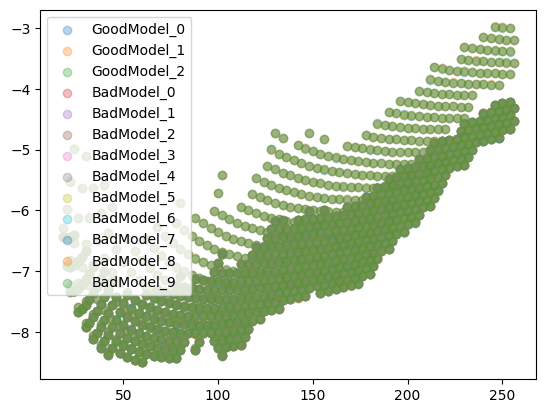

In [ ]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.145011  1.332955 -0.124098  0.059359  0.137564
GoodModel_1 -6.144941  1.333104 -0.124167  0.059364  0.137628
GoodModel_2 -6.144898  1.333020 -0.124211  0.059391  0.137680
BadModel_0  -6.737298  1.034249  0.468189  0.362164  0.591915
BadModel_1  -6.737343  1.034290  0.468234  0.362152  0.591944
BadModel_2  -6.737276  1.034290  0.468167  0.362160  0.591896
BadModel_3  -6.737292  1.034247  0.468183  0.362220  0.591945
BadModel_4  -6.737254  1.034259  0.468145  0.362164  0.591881
BadModel_5  -6.737248  1.034194  0.468139  0.362244  0.591925
BadModel_6  -6.737267  1.034216  0.468159  0.362229  0.591931
BadModel_7  -6.737221  1.034237  0.468113  0.362187  0.591869
BadModel_8  -6.737264  1.034244  0.468155  0.362147  0.591878
BadModel_9  -6.737323  1.034236  0.468214  0.362189  0.591951
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.15 & 1.33 & -0.12 & 0.06 & 0.14 \\
GoodModel_1

### Scenario - 1 perfect model, 10 levels of increasing noise

In [ ]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "3g10bNoise"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 3
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term


n_class_4 = 10
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

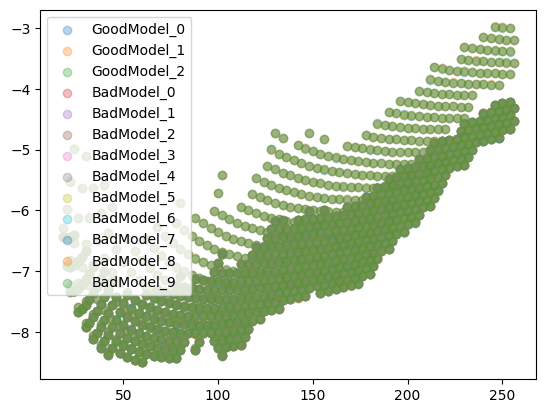

In [ ]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.145011  1.332955 -0.124098  0.059359  0.137564
GoodModel_1 -6.144941  1.333104 -0.124167  0.059364  0.137628
GoodModel_2 -6.144898  1.333020 -0.124211  0.059391  0.137680
BadModel_0  -6.737298  1.034249  0.468189  0.362164  0.591915
BadModel_1  -6.737343  1.034290  0.468234  0.362152  0.591944
BadModel_2  -6.737276  1.034290  0.468167  0.362160  0.591896
BadModel_3  -6.737292  1.034247  0.468183  0.362220  0.591945
BadModel_4  -6.737254  1.034259  0.468145  0.362164  0.591881
BadModel_5  -6.737248  1.034194  0.468139  0.362244  0.591925
BadModel_6  -6.737267  1.034216  0.468159  0.362229  0.591931
BadModel_7  -6.737221  1.034237  0.468113  0.362187  0.591869
BadModel_8  -6.737264  1.034244  0.468155  0.362147  0.591878
BadModel_9  -6.737323  1.034236  0.468214  0.362189  0.591951
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.15 & 1.33 & -0.12 & 0.06 & 0.14 \\
GoodModel_1

## PCA - Analysis (not centering)

###  1 Good 1 Bad (noise)

In [346]:
np.shape(residuals)

(521, 2)

In [347]:
U, S, Vt = np.linalg.svd(model_predictions)

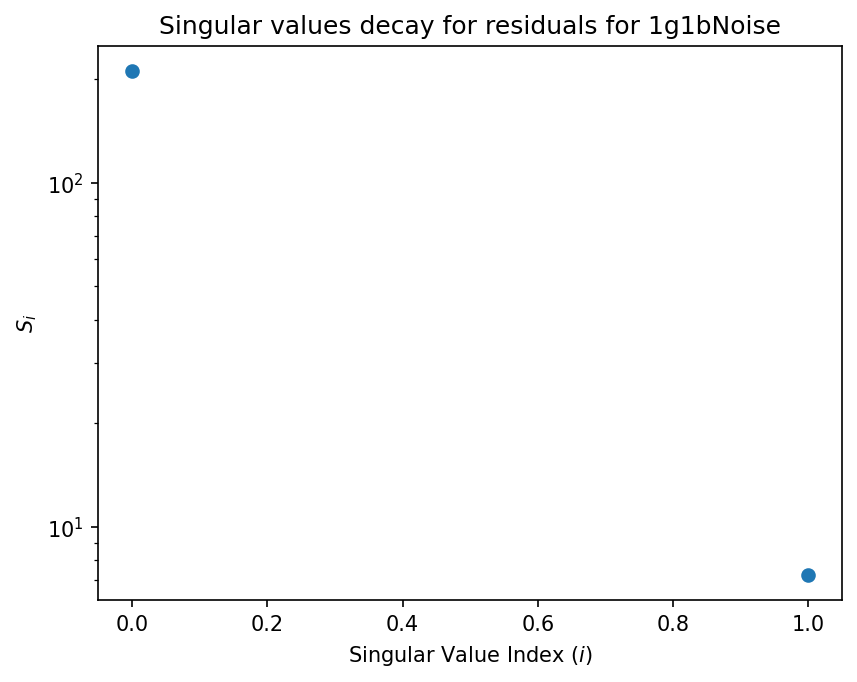

In [348]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');
plt.title("Singular values decay for residuals for " +scenario)
plt.show()

In [349]:
components_kept=2
S_hat=np.array([S[i] for i in range(components_kept)])

U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)]).T

Vt_hat=np.array([Vt[i] for i in range(components_kept)])


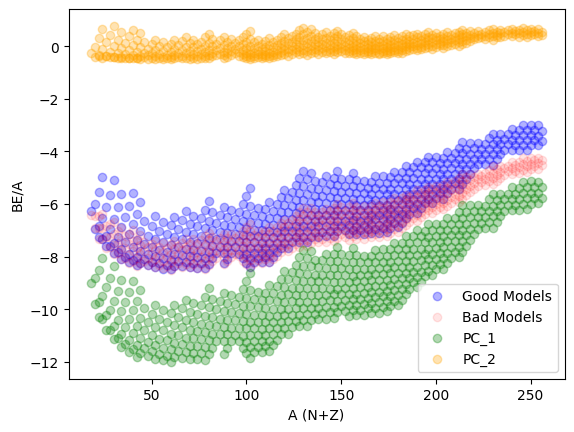

In [351]:
key_list=list(models_output.keys())


legend_flag=0
for key in key_list[0:1]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = 'Good Models', alpha = 0.3,color='b')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.3,color='b')

legend_flag=0
for key in key_list[1:]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = "Bad Models", alpha = 0.1,color='r')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.1,color='r')



# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y = U_hat.T[0], label = str("PC_") + str(1), alpha = 0.3,color='g')
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(2), alpha = 0.3,color='orange')
plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

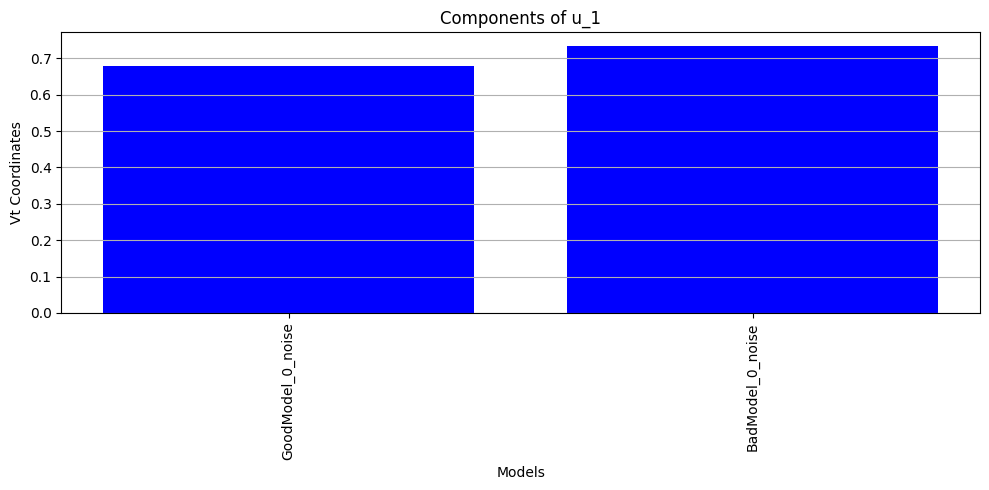

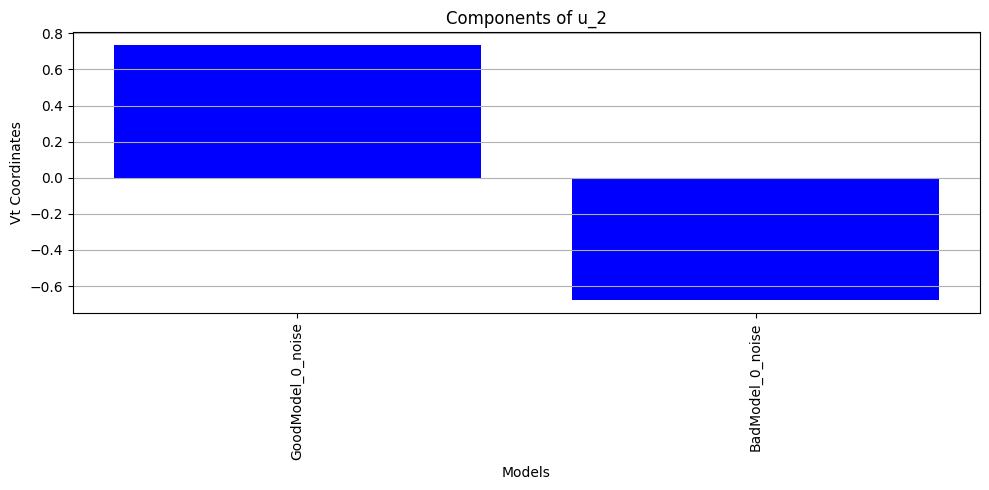

In [352]:
labels_list = list(models_output.keys())

for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], labels_list, title=f"Components of u_{i+1}", color='blue')

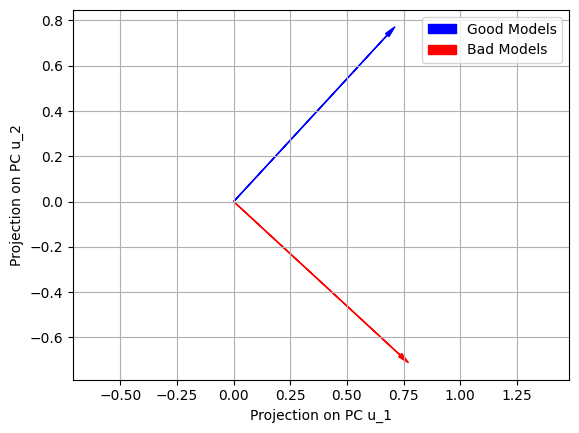

In [353]:

list1 = Vt_hat.T[0:1]
list2 = Vt_hat.T[1:] 

# Create the plot
plt.figure()
plt.grid(True)

legend_flag=0
for x, y in list1:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue',label='Good Models')
    else:
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue')


legend_flag=0
for x, y in list2:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red',label="Bad Models")
    else:
       plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red') 

# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-max_val-1, max_val+1)
# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC u_1')
plt.ylabel('Projection on PC u_2')

plt.legend()

plt.axis('equal')

plt.show()


In [354]:
X=np.copy(U_hat).T
y=np.copy(masses_truth.tolist())

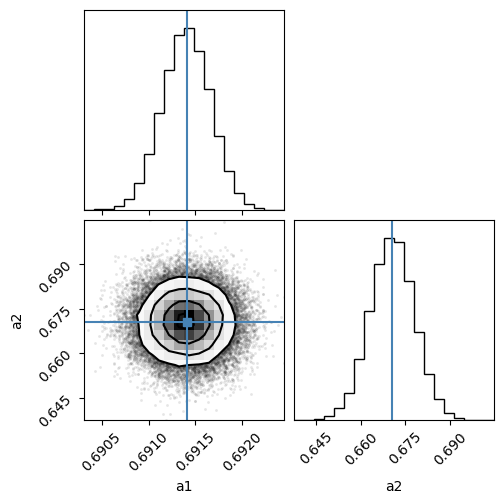

In [355]:
# 1) Find the least square solution
X_T_X_inv = np.linalg.inv(X.dot(X.T))
beta = X_T_X_inv.dot(X).dot(y)
supermodel=X.T.dot(beta)

# 2) Construct the covariance matrix
residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=50000)
figure = corner.corner(samples, labels=[f'a{i}' for i in range(1, len(beta) + 1)], truths=beta)

plt.show()

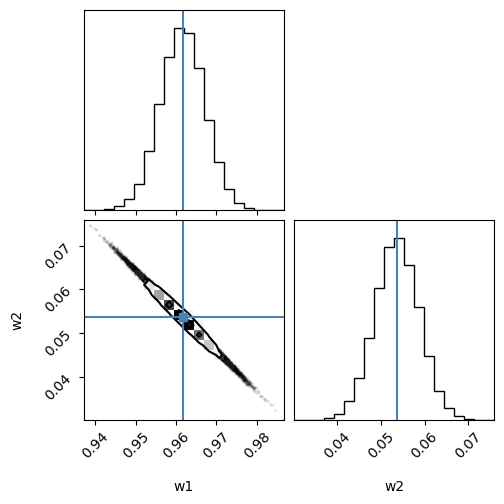

In [356]:
# 4) Make a corner plot in the space of the original models
samples_original_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


figure = corner.corner(samples_original_space, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat))
# figure = corner.corner(samples_original_space)

plt.show()

In [357]:
beta

array([0.69140697, 0.6705039 ])

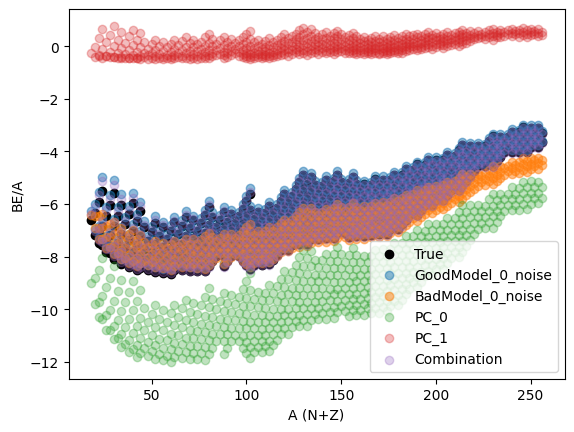

In [358]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = masses_truth.values[:,None], label = str("True"), color='k')



for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# 


# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y =U_hat.T[0], label = str("PC_") + str(0), alpha = 0.3)
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = supermodel, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [359]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
                     (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

In [360]:
Predictions_supermodel=supermodel[filtered_models_output.index]
masses_truth_filtered= np.array(masses_truth.tolist())[filtered_models_output.index]

In [361]:
masses_truth_filtered

array([-8.40668771, -8.34027003, -8.18890254, -7.97132217, -7.70318603,
       -7.3972354 , -7.0636683 , -6.71055621])

In [362]:
Predictions_supermodel

array([-8.34583123, -8.26398132, -8.13443376, -7.92291959, -7.63928648,
       -7.33451883, -6.98519426, -6.62202917])

In [363]:
rng = np.random.default_rng()
theta_rand = rng.choice(samples, (50000), replace=False)
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand= X.T.dot(theta_rand[i])[filtered_models_output.index]
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(masses_truth_filtered)
                       ,0), np.diag(1.0 * np.full(len(masses_truth_filtered),1.0 * sigma_squared ) )))   

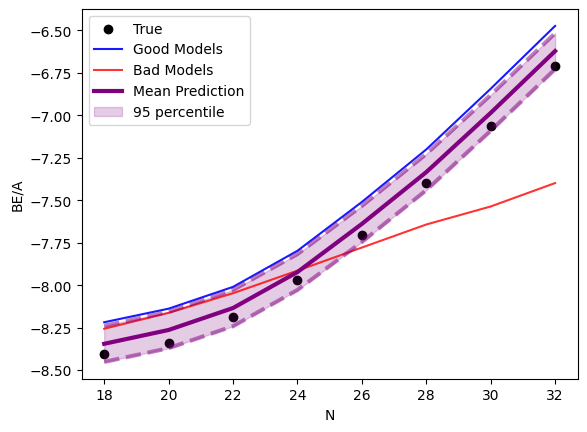

In [365]:
plt.scatter(x = filtered_models_output["N"], y = masses_truth_filtered, label = str("True"), color='k')




#good  models
legend_flag=0
for key in list(models_output.keys())[:1]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Good Models", color='b',alpha = 0.9)
        legend_flag=1
    else:
        plt.plot( filtered_models_output["N"], filtered_models_output[key], color='b',alpha = 0.5)

#bad models
legend_flag=0
for key in list(models_output.keys())[1:]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Bad Models", color ='r',alpha = 0.8)
        legend_flag=1
    else:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], color='r',alpha = 0.5)




# middle_index=len(masses_truth_filtered) // 2
# # for i in range(components_kept):
# plt.plot(filtered_models_output["N"],  U_hat.T[0][filtered_models_output.index]/(U_hat.T[0][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(0), alpha = 0.3)
# plt.plot(filtered_models_output["N"],U_hat.T[1][filtered_models_output.index]/(U_hat.T[1][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)





mean = np.mean(rndm_m,axis=0)
upper = (np.percentile(rndm_m, 97.5, axis=0))



lower = (np.percentile(rndm_m, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='Mean Prediction',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2, label='95 percentile')



plt.legend()

plt.xlabel('N')

plt.ylabel('BE/A')

plt.show()

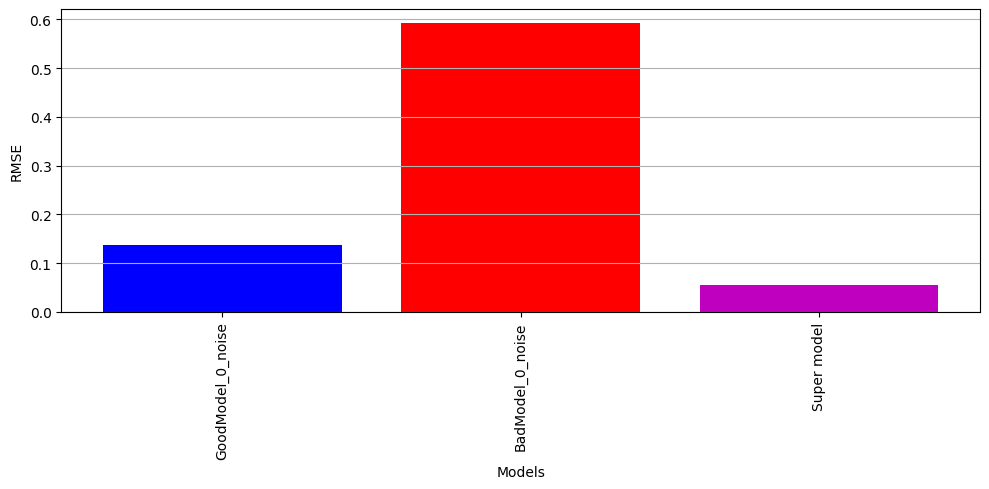

In [371]:
labels=list(models_output.keys())
plt.figure(figsize=(10, 5))
plt.bar(labels[0:1] , model_summary["rmse"][0:1], color='b')

plt.bar(labels[1:] , model_summary["rmse"][1:], color='r')

plt.bar('Super model' , np.sqrt(sigma_squared), color='m')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(labels+['Super model'],fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

###  3 Good 10 Bad (noise)

In [75]:
np.shape(residuals)

(521, 13)

In [76]:
U, S, Vt = np.linalg.svd(model_predictions)

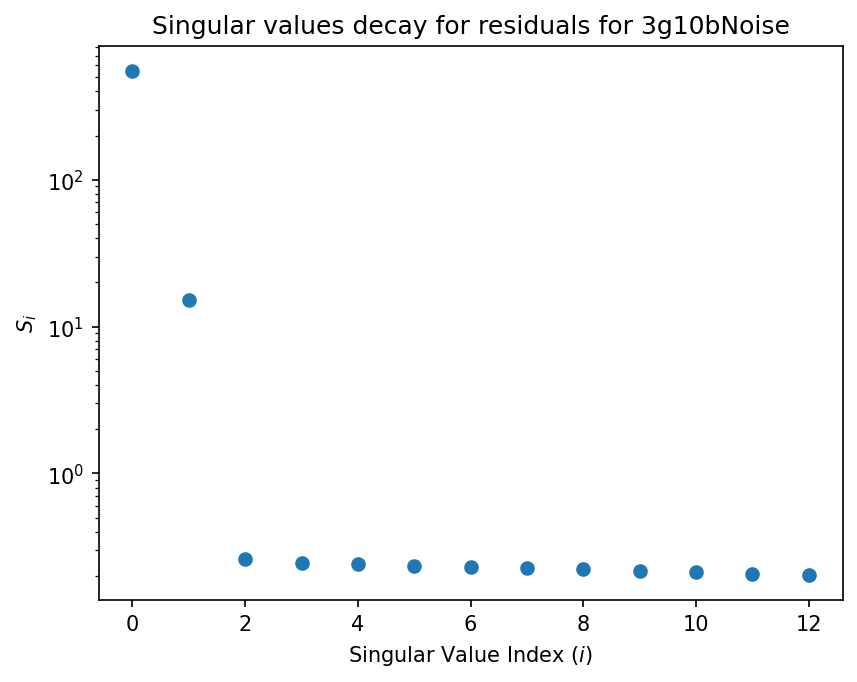

In [77]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');
plt.title("Singular values decay for residuals for " +scenario)
plt.show()

In [202]:
components_kept=2
S_hat=np.array([S[i] for i in range(components_kept)])

U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)]).T

Vt_hat=np.array([Vt[i] for i in range(components_kept)])


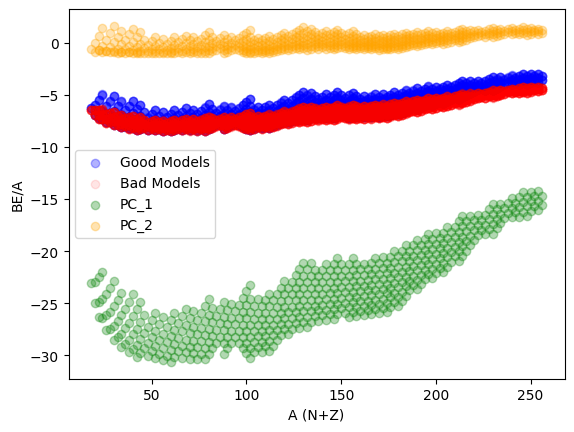

In [339]:
key_list=list(models_output.keys())


legend_flag=0
for key in key_list[0:3]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = 'Good Models', alpha = 0.3,color='b')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.3,color='b')

legend_flag=0
for key in key_list[3:]:
    if legend_flag==0:
        legend_flag=1
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = "Bad Models", alpha = 0.1,color='r')
    else:
        plt.scatter(x = models_output_df["A"], y = models_output_df[key], alpha = 0.1,color='r')



# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y = U_hat.T[0], label = str("PC_") + str(1), alpha = 0.3,color='g')
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(2), alpha = 0.3,color='orange')
plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

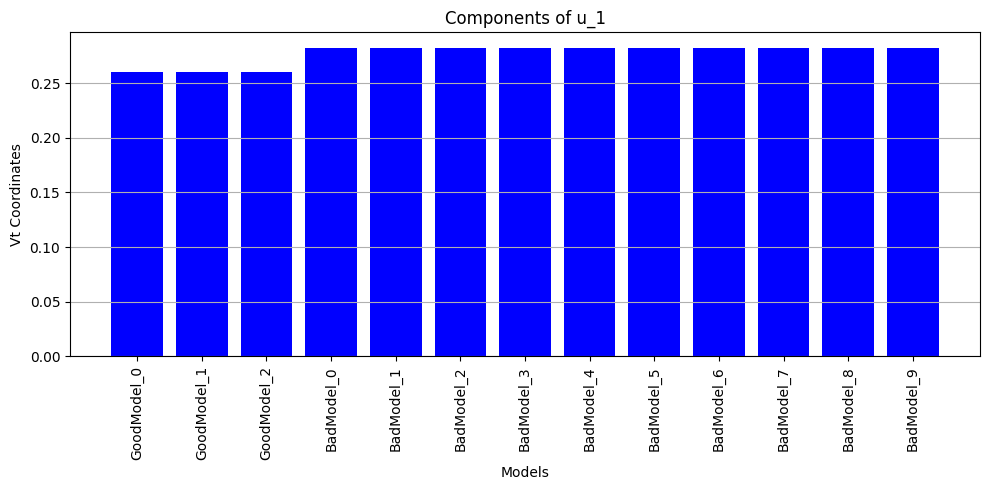

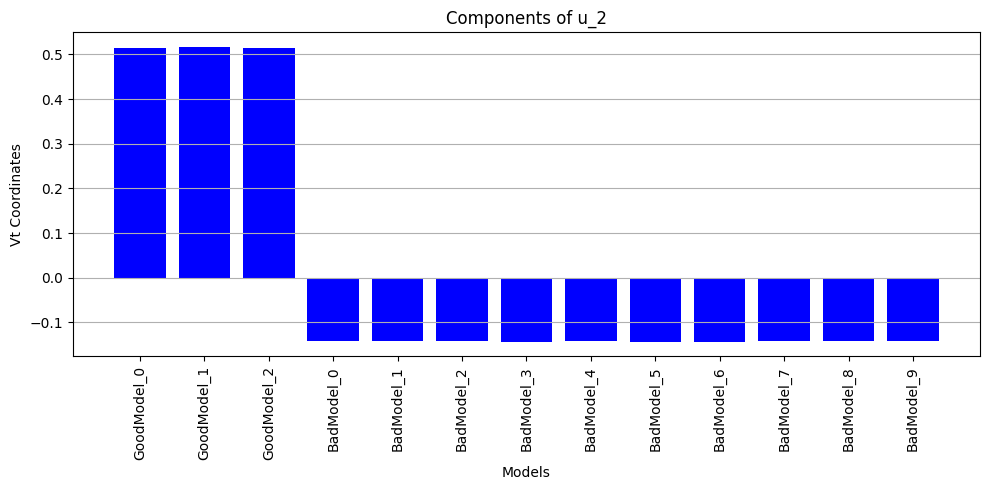

In [312]:
labels_list = list(models_output.keys())

for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], labels_list, title=f"Components of u_{i+1}", color='blue')

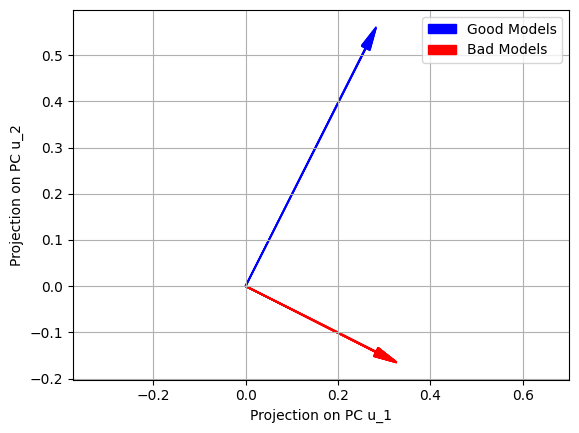

In [311]:

list1 = Vt_hat.T[0:3]
list2 = Vt_hat.T[3:] 

# Create the plot
plt.figure()
plt.grid(True)

legend_flag=0
for x, y in list1:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue',label='Good Models')
    else:
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='blue', ec='blue')


legend_flag=0
for x, y in list2:
    if legend_flag==0:
        legend_flag=1
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red',label="Bad Models")
    else:
       plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='red', ec='red') 

# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-max_val-1, max_val+1)
# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC u_1')
plt.ylabel('Projection on PC u_2')

plt.legend()

plt.axis('equal')

plt.show()


In [211]:
X=np.copy(U_hat).T
y=np.copy(masses_truth.tolist())

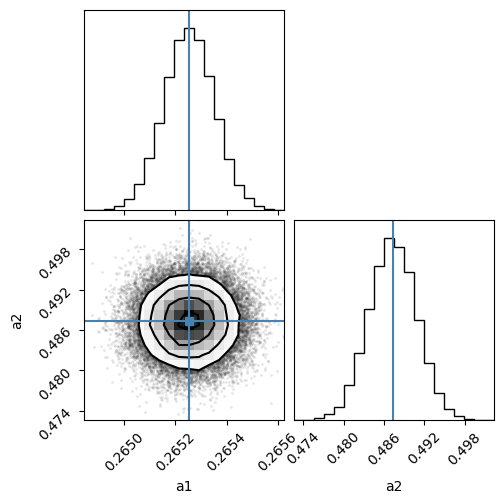

In [212]:
# 1) Find the least square solution
X_T_X_inv = np.linalg.inv(X.dot(X.T))
beta = X_T_X_inv.dot(X).dot(y)
supermodel=X.T.dot(beta)

# 2) Construct the covariance matrix
residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=50000)
figure = corner.corner(samples, labels=[f'a{i}' for i in range(1, len(beta) + 1)], truths=beta)

plt.show()

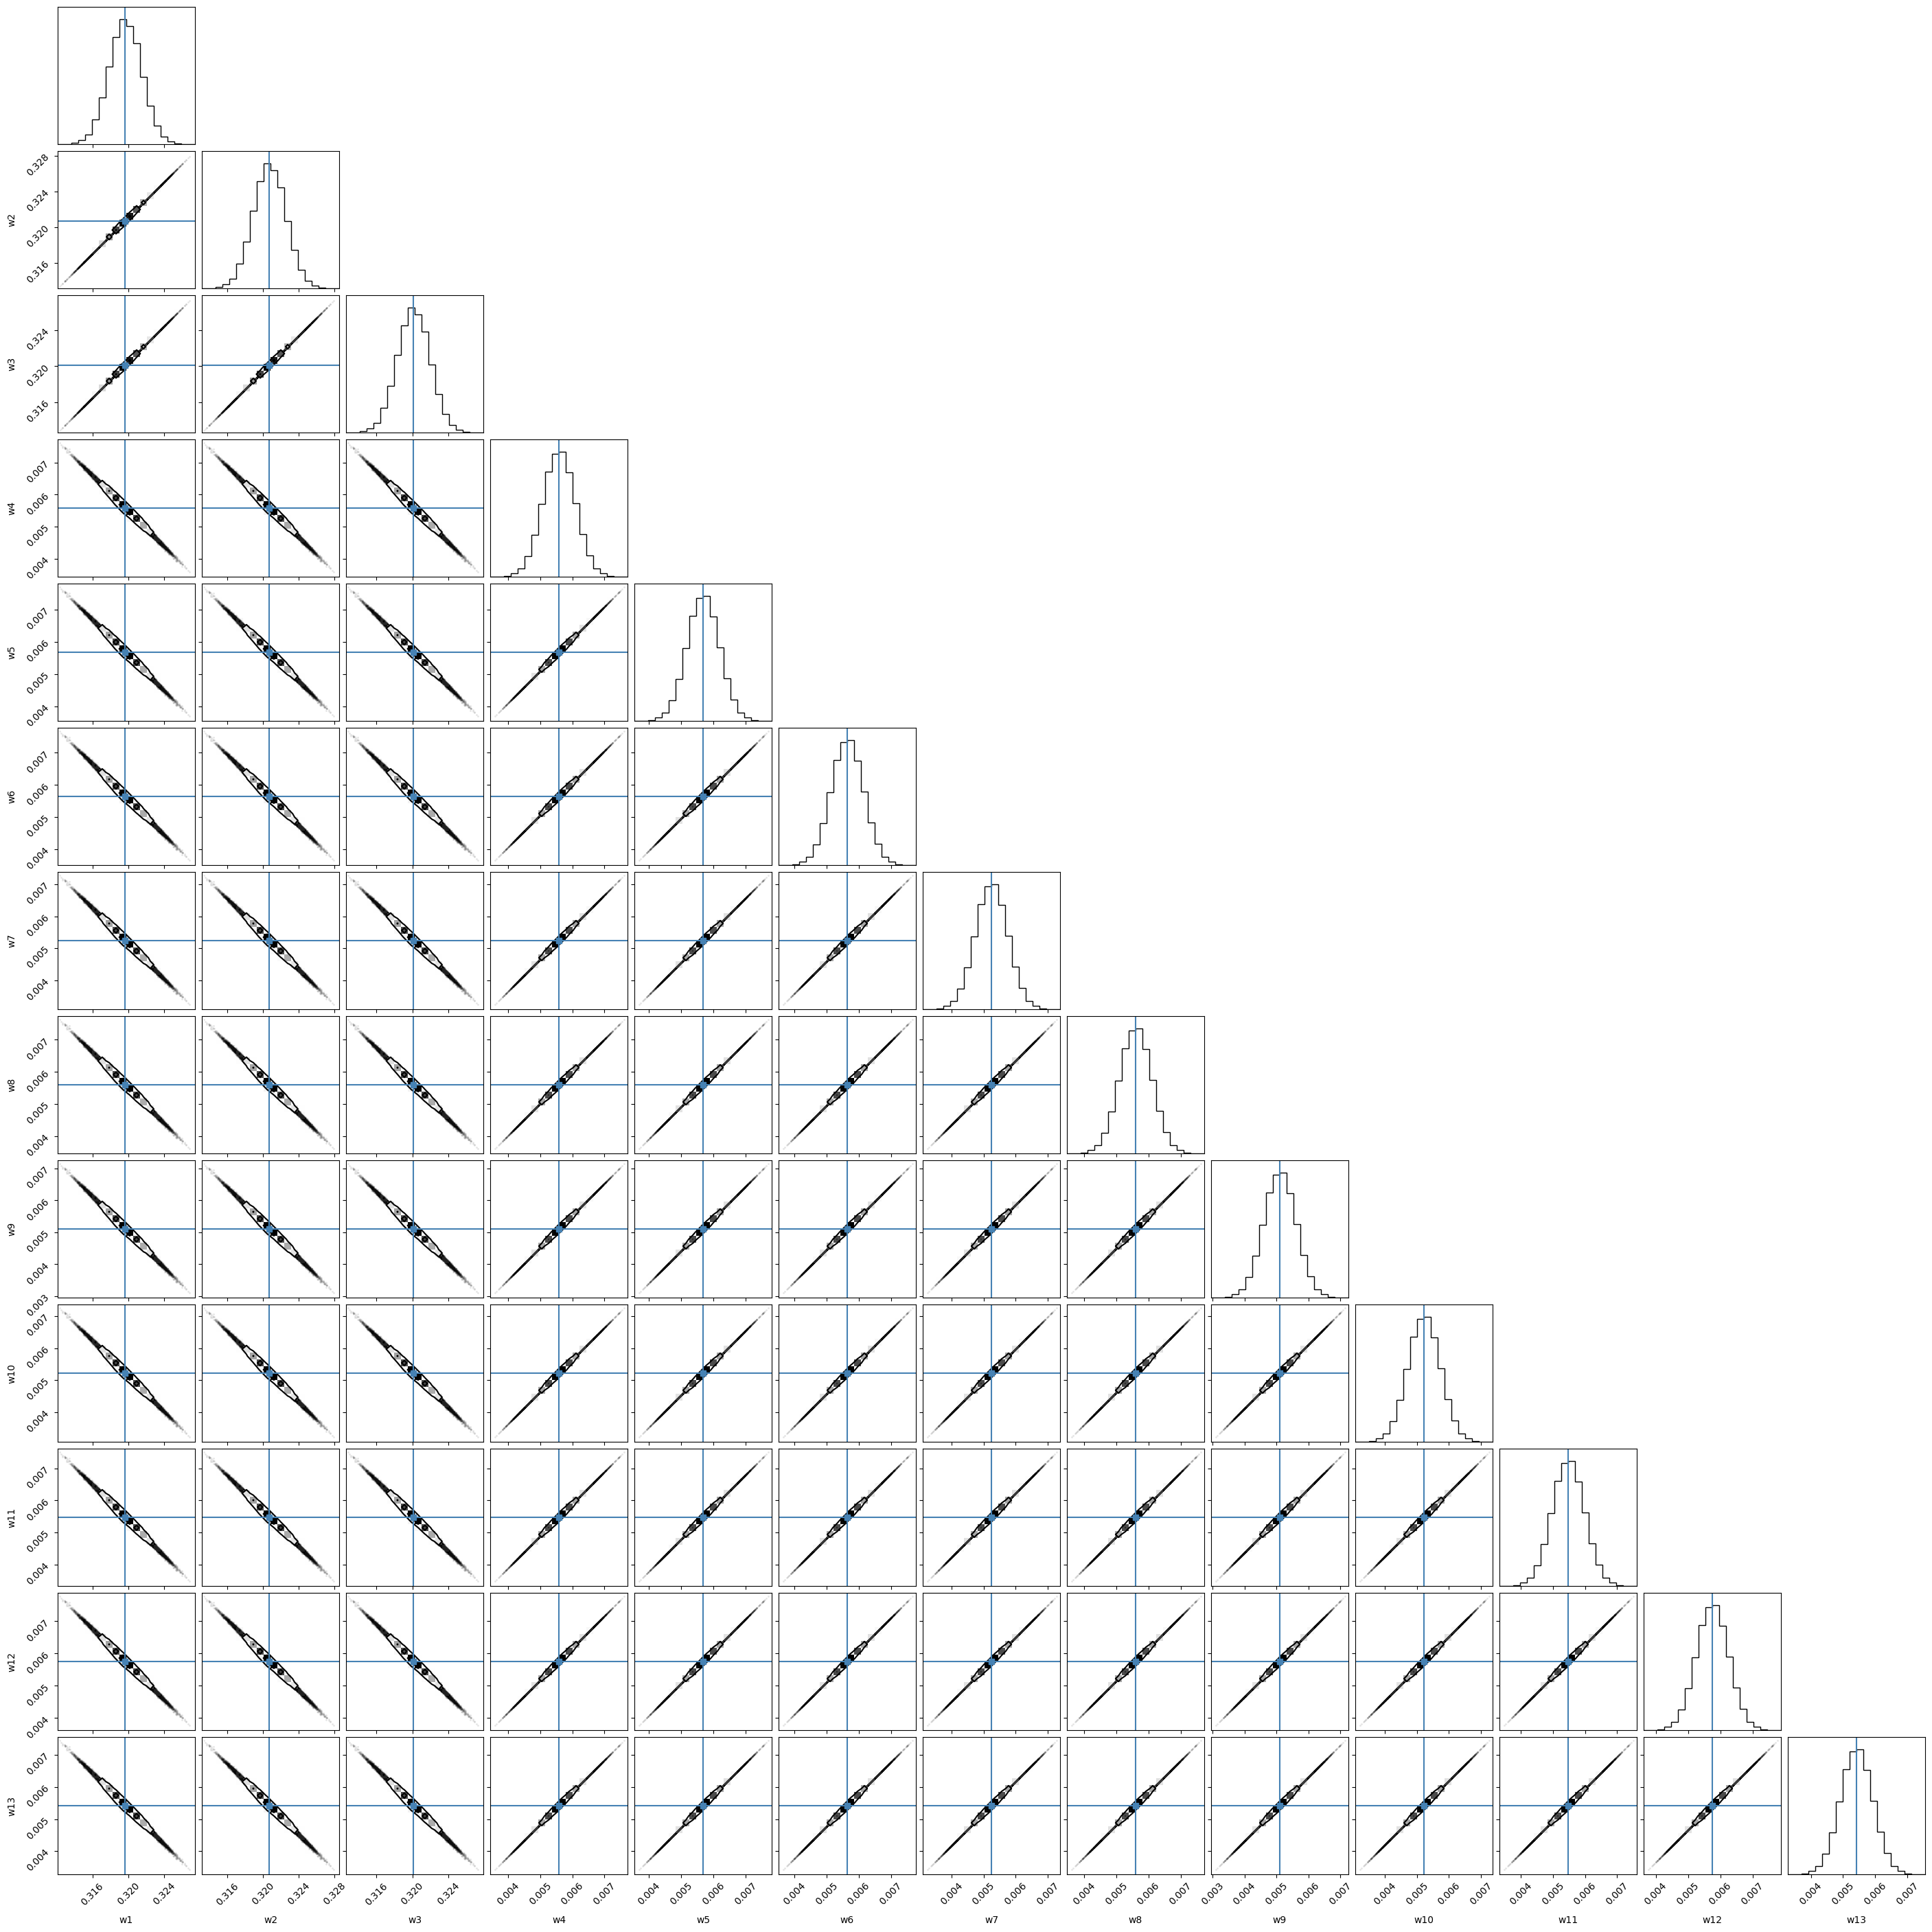

In [263]:
# 4) Make a corner plot in the space of the original models
samples_original_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


figure = corner.corner(samples_original_space, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat))
# figure = corner.corner(samples_original_space)

plt.show()

In [264]:
beta

array([0.26525345, 0.4872735 ])

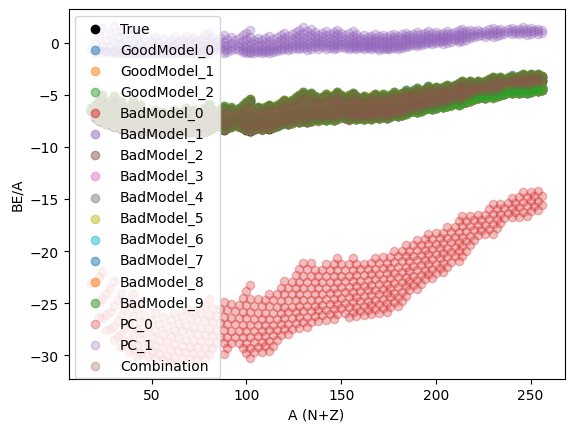

In [265]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = masses_truth.values[:,None], label = str("True"), color='k')



for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# 


# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y =U_hat.T[0], label = str("PC_") + str(0), alpha = 0.3)
plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = supermodel, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [266]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
                     (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

In [267]:
Predictions_supermodel=supermodel[filtered_models_output.index]
masses_truth_filtered= np.array(masses_truth.tolist())[filtered_models_output.index]

In [268]:
masses_truth_filtered

array([-8.40668771, -8.34027003, -8.18890254, -7.97132217, -7.70318603,
       -7.3972354 , -7.0636683 , -6.71055621])

In [269]:
Predictions_supermodel

array([-8.33775038, -8.2806572 , -8.14129448, -7.91619521, -7.63868216,
       -7.32438315, -6.98648626, -6.62226156])

In [270]:
rng = np.random.default_rng()
theta_rand = rng.choice(samples, (50000), replace=False)
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand= X.T.dot(theta_rand[i])[filtered_models_output.index]
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(masses_truth_filtered)
                       ,0), np.diag(1.0 * np.full(len(masses_truth_filtered),1.0 * sigma_squared ) )))   

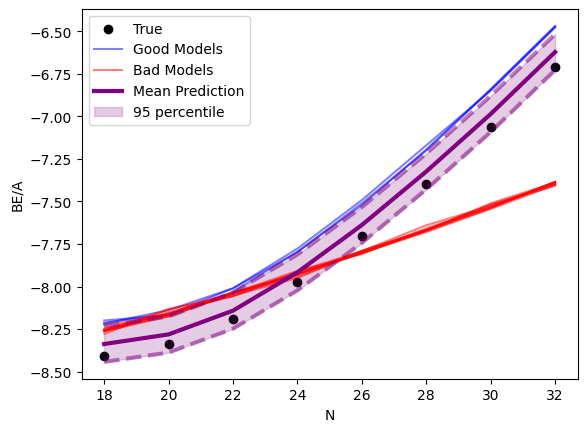

In [271]:
plt.scatter(x = filtered_models_output["N"], y = masses_truth_filtered, label = str("True"), color='k')




#good  models
legend_flag=0
for key in list(models_output.keys())[:3]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Good Models", color='b',alpha = 0.5)
        legend_flag=1
    else:
        plt.plot( filtered_models_output["N"], filtered_models_output[key], color='b',alpha = 0.5)

#bad models
legend_flag=0
for key in list(models_output.keys())[3:]:
    if legend_flag==0:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], label = "Bad Models", color ='r',alpha = 0.5)
        legend_flag=1
    else:
        plt.plot(filtered_models_output["N"], filtered_models_output[key], color='r',alpha = 0.5)




# middle_index=len(masses_truth_filtered) // 2
# # for i in range(components_kept):
# plt.plot(filtered_models_output["N"],  U_hat.T[0][filtered_models_output.index]/(U_hat.T[0][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(0), alpha = 0.3)
# plt.plot(filtered_models_output["N"],U_hat.T[1][filtered_models_output.index]/(U_hat.T[1][filtered_models_output.index][middle_index])*(masses_truth_filtered[middle_index]), label = str("PC_") + str(1), alpha = 0.3)


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)





mean = np.mean(rndm_m,axis=0)
upper = (np.percentile(rndm_m, 97.5, axis=0))



lower = (np.percentile(rndm_m, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='Mean Prediction',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2, label='95 percentile')



plt.legend()

plt.xlabel('N')

plt.ylabel('BE/A')

plt.show()

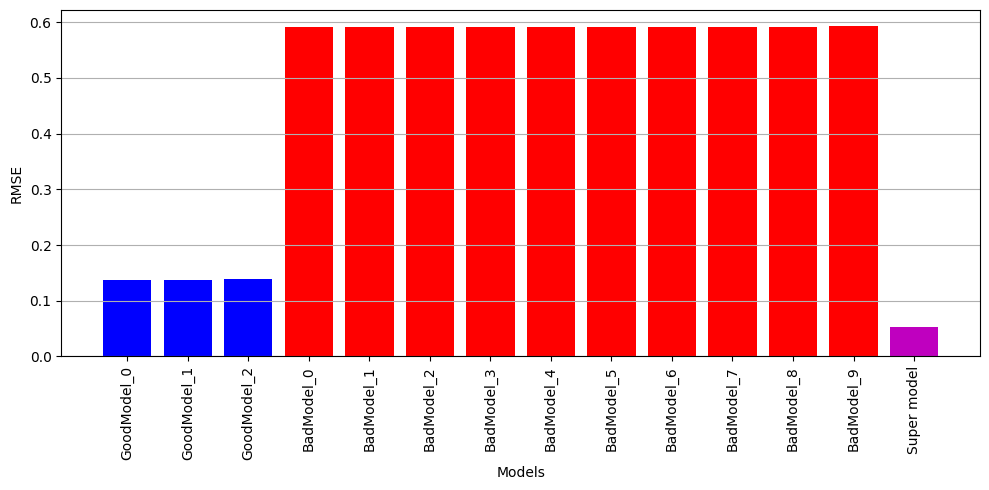

In [325]:
labels=list(models_output.keys())
plt.figure(figsize=(10, 5))
plt.bar(labels[0:3] , model_summary["rmse"][0:3], color='b')

plt.bar(labels[3:] , model_summary["rmse"][3:], color='r')

plt.bar('Super model' , np.sqrt(sigma_squared), color='m')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(labels+['Super model'],fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [372]:
np.sqrt(sigma_squared)

0.05417892829070963